# Tutorial 1: Exploring EvalRS dataset

In [2]:
# !git clone https://github.com/Reclist/reclist/
# !cd reclist ; pip install -e .

# !git clone https://github.com/RecList/evalRS-KDD-2023
# !cd evalRS-KDD-2023 ; git checkout readme_kdd_2023

In [ ]:
# !pip install seaborn

In [4]:
# !which python
# !pip install -r evalRS-KDD-2023/requirements.txt

In [1]:
import os
import sys
sys.path.insert(0, 'evalRS-KDD-2023/evaluation')

In [2]:
from EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

sns.set_theme("notebook")

/Users/mayanksingh/VSCodeProjects/metrics-customerN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
dataset = ChallengeDataset(force_download=False)

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating Train/Test Split.
Generating dataset hashes.


In [5]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6869679, 6), (29722, 3))

In [6]:
# ??ChallengeDataset

In [7]:
# basically interaction data. Listening events
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
0,50967444,3059,114114,336613,1409538054,1
1,50967444,3059,114114,336156,1409537916,1
2,50967444,3059,114114,339139,1409537712,1
4,50967444,677,3035,674449,1409532988,1
5,50967444,677,3035,639652,1409532015,1


Sample evaluation loop

In [19]:
# !cd evaluation
# !python eval.py   

In [8]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [9]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1
4,50967444,677,3035,674449,2014-09-01 00:56:28,1
5,50967444,677,3035,639652,2014-09-01 00:40:15,1


In [10]:
# add a column for Hour Of the Day
train["hod"] = train["timestamp"].dt.hour

## EDA on tracks

In [11]:
percentiles = np.arange(1, step=0.1)
gb_track = train.groupby("track_id")

### What's the track distribution?

In [14]:
track_records = gb_track.size()
# track_records.head()
track_records.describe(percentiles=percentiles) # song listens range from 8 to 1608, median is 17

count    228044.000000
mean         30.124358
std          41.741419
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          26.000000
80%          36.000000
90%          59.000000
max        1608.000000
dtype: float64

In [16]:
len(train.groupby(["user_id", "track_id"]).size()) == train.shape[0] # no duplicate counts at user-track level  

True

user_track_count tells us the number of times a user played that particular track

Look at the track distribution, how many users played a track

Text(0, 0.5, 'Number of Tracks (log)')

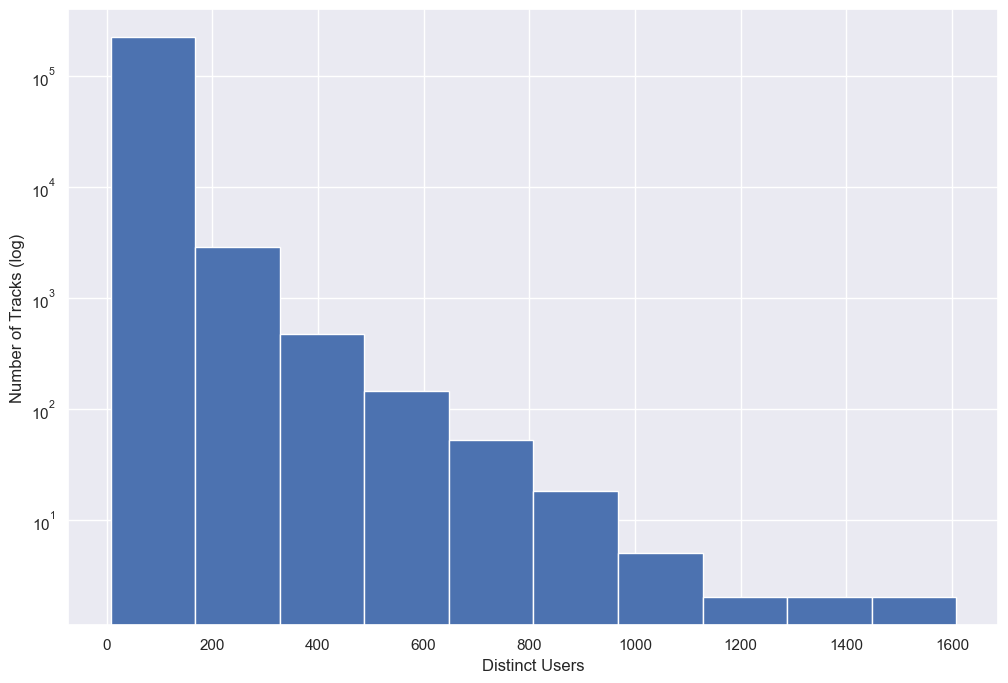

In [22]:
fix, ax = plt.subplots(figsize=(12, 8))
ax.hist(track_records)
ax.set_yscale("log")
ax.set_xlabel("Distinct Users")
ax.set_ylabel("Number of Tracks (log)")

### Outlier troubleshooting

In [23]:
K = 10
top_by_user = track_records.iloc[track_records.argsort().values[:-(K+1):-1]]
top_by_user.name = "distinct_user_count"

# Retrieve the task information from the `dataset` handler variable
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,distinct_user_count
track_id,,,,,,,,,,,,,
4868,Rolling in the Deep,504,Adele,"[1518, 18942, 64876, 66600, 80986, 93573, 9761...","['21', '19', '21 (Deluxe Edition)', 'monday_pl...",http://lyrics.wikia.com/Adele:Rolling_In_The_Deep,0.390623,-0.263898,None,None,None,True,1608
26142,We Are Young (feat. Janelle Monáe),3151,fun.,"[6907, 9619, 53139, 162664, 238945, 246098, 27...","['Some Nights', 'We Are Young', nan, 'The Best...",None,NaN,NaN,None,None,None,None,1476
11393952,Somebody That I Used to Know,3085,Gotye,"[20107, 33321, 90034, 103479, 107493, 158828, ...","['Making Mirrors (Deluxe Edition)', 'Somebody ...",http://lyrics.wikia.com/Gotye:Somebody_That_I_...,-0.383686,-0.720571,None,None,None,True,1376
16110,Get Lucky (feat. Pharrell Williams),320,Daft Punk,"[5331, 10200, 11728, 40809, 84112, 95892, 1237...","['Random Access Memories', 'Get Lucky', 'Homew...",None,NaN,NaN,None,None,None,None,1337
14034,We Found Love (feat. Calvin Harris),355,Rihanna,"[4961, 6808, 14253, 18206, 18254, 19802, 40014...","['We Found Love', 'The Official Uk Top 40 Sing...",None,NaN,NaN,None,None,None,None,1281
51176,Titanium (feat. Sia),1935,David Guetta,"[16065, 18345, 18845, 32658, 40236, 80698, 875...","['Best of...', 'Nothing but the Beat 2.0', 'No...",None,NaN,NaN,None,None,None,None,1128
572665,Set Fire to the Rain,504,Adele,"[1518, 64876, 93573, 98525, 116649, 143113, 14...","['21', '21 (Deluxe Edition)', 'Rolling in the ...",http://lyrics.wikia.com/Adele:Set_Fire_To_The_...,-0.428821,-0.415065,None,None,None,False,1086
28847,Get Lucky (Radio Edit) [feat. Pharrell Williams],320,Daft Punk,"[10200, 19277, 136209, 188202, 269754, 361728,...","['Get Lucky', nan, 'Random Access Memories', '...",None,NaN,NaN,None,None,None,None,1076
2498,Blue Jeans,402,Lana Del Rey,"[1066, 4509, 12831, 20462, 20475, 20735, 79820...","['Born to Die', 'Born to Die - The Paradise Ed...",http://lyrics.wikia.com/Lana_Del_Rey:Blue_Jeans,0.278431,-0.109800,None,None,None,False,1007


These are popular songs, there are repeated entries for different versions of the same song (Get Lucky)

### How often does a user play the same song?

In [30]:
avg_play_count = gb_track['user_track_count'].mean()
avg_play_count.describe(percentiles) # avg times a song is heard by the same user ~2.6

count    228044.000000
mean          2.552850
std           2.512765
min           1.000000
0%            1.000000
10%           1.250000
20%           1.416667
30%           1.583333
40%           1.761905
50%           1.983607
60%           2.233987
70%           2.596154
80%           3.151515
90%           4.267815
max         261.692308
Name: user_track_count, dtype: float64

Let's observe the tail items

In [41]:
K = 10
top_by_user = avg_play_count.iloc[avg_play_count.argsort().values[:-(K+1):-1]] # get the top 10 avg listen per user songs
top_by_user.name = "avg_play_count"
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,avg_play_count
track_id,,,,,,,,,,,,,
176516,20.000 Miles Over the Sea,48,Enigma,"[917, 60733]","['A Posteriori', 'A Posteriori (Advance)']",http://lyrics.wikia.com/Enigma:20.000_Miles_Ov...,-0.076169,-0.118055,TRXFLYS128EF3553D4,True,True,False,261.692308
361822,Bury Me in Vegas,14005,Eskimo Callboy,[125035],['Bury Me in Vegas'],http://lyrics.wikia.com/Eskimo_Callboy:Bury_Me...,0.258987,-0.205667,None,None,None,False,239.464286
2746593,Whatever,16858,4minute,"[134302, 1097460, 4794617]","['Name Is 4minute', 'Name Is 4minute', 'Name I...",None,NaN,NaN,None,None,None,None,189.600000
362676,Youth Gone Wild (Skid Row cover),8988,Asking Alexandria,"[84931, 118455, 125624]","['Life Gone Wild', 'Life Gone Wild EP', 'Life ...",None,NaN,NaN,None,None,None,None,175.133333
34135,Slow Emotion Replay,6167,The The,"[12317, 67220, 233928, 319619, 319624, 339975,...","['Dusk', 'London Town 1983-1993', '45 RPM: The...",http://lyrics.wikia.com/The_The:Slow_Emotion_R...,0.122632,-0.443743,None,None,None,False,136.947368
177,Gravity of Love,48,Enigma,"[72, 336, 1489, 10686, 60702, 195575, 195621, ...",['Love Sensuality Devotion - The Greatest Hits...,http://lyrics.wikia.com/Enigma:Gravity_Of_Love,-0.216604,0.197573,TRQSKNG128F146A48C,True,True,False,130.071429
840071,Going Nowhere Fast,18713,Joey Ramone,"[308233, 339655, 464406, 1352501]","['ya know', '...ya know?', '...ya know?', 'Ya ...",http://lyrics.wikia.com/Joey_Ramone:Going_Nowh...,0.193137,-0.180341,None,None,None,False,129.750000
993722,We Believe,59718,David Cook,"[185432, 345497, 3655166, 4282962]","['This Loud Morning (Deluxe Version)', 'This L...",http://lyrics.wikia.com/David_Cook:We_Believe,-0.025612,0.159226,None,None,None,False,127.100000
639125,Silver City,67671,Ghostland Observatory,"[229029, 400187, 1467560, 9877205]",['Live at Austin City Limits Music Festival 20...,http://lyrics.wikia.com/Ghostland_Observatory:...,0.106483,0.093438,TRVGPHZ128F424E442,True,True,False,120.882353


Top-10 tracks by number of play counts (per user) is different from the top tracks by unique listeners

In [42]:
# cleanup

del gb_track
del avg_play_count
del track_records
del top_by_user
_ = gc.collect() # clears memory by running garbage collector

## WASABI Features

- WASABI dataset contains song metadata and human labeled features
- Doesn't exist for all songs in the tracks dataset

In [46]:
train_tracks = train.join(dataset.df_tracks, on="track_id", rsuffix="_data")

In [48]:
train_tracks.head(3)

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod,track,artist_id_data,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1,2,Holland,3059,Sufjan Stevens,"[114114, 150921, 200774, 223026, 285370, 28908...",['Greetings From Michigan: The Great Lakes Sta...,http://lyrics.wikia.com/Sufjan_Stevens:Holland,-0.160209,-0.154524,TRYYCFI128F427EEF5,True,True,False
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1,2,Tahquamenon Falls,3059,Sufjan Stevens,"[114114, 150921, 200774, 223026, 285370, 28908...",['Greetings From Michigan: The Great Lakes Sta...,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1,2,The Upper Peninsula,3059,Sufjan Stevens,"[114114, 150921, 200774, 223026, 285370, 28908...",['Greetings From Michigan: The Great Lakes Sta...,http://lyrics.wikia.com/Sufjan_Stevens:The_Upp...,-0.306198,-0.405807,None,None,None,False


Looking at the coverage of each feature:

In [49]:
for feat in ['arousal_predicted', 'valence_predicted',
             'isClassic', 'has_social_tags', 'has_emotion_tags']:

    perc_tracks = np.sum(dataset.df_tracks[feat].notna())/len(dataset.df_tracks)
    perc_events = np.sum(train_tracks[feat].notna())/len(train_tracks)
    print(f"'{feat}': {round(perc_tracks,2)} tracks, {round(perc_events,2)} events")

'arousal_predicted': 0.51 tracks, 0.79 events
'valence_predicted': 0.51 tracks, 0.79 events
'isClassic': 0.51 tracks, 0.79 events
'has_social_tags': 0.17 tracks, 0.31 events
'has_emotion_tags': 0.17 tracks, 0.31 events


Topics features coverage:

In [50]:
train_topics = train_tracks.join(dataset.df_topics, on="urlSong", rsuffix="_data")
np.sum(train_topics.topics.notna())/len(train_topics)

0.6913522451340157

Song embeddings coverage:

In [51]:
train_embs = train_tracks.join(dataset.df_song_embeddings, on="urlSong", rsuffix="_data")
np.sum(train_embs.song_embedding.notna())/len(train_embs)

0.7797409456831972

### Using Topics

In [54]:
dataset.df_topics.head(3)

,topics
urlSong,
http://lyrics.wikia.com/3_Doors_Down:Away_From_The_Sun,"[0.022949012, 0.010859559, 0.0, 0.0, 0.0170614..."
http://lyrics.wikia.com/3_Doors_Down:Back_To_Me,"[0.010902543, 0.0, 0.0, 0.0, 0.014221805, 0.01..."
http://lyrics.wikia.com/3_Doors_Down:Be_Like_That,"[0.0, 0.0270662, 0.018602224, 0.0, 0.060051907..."


In [59]:
descr = []
for urlSong in list(dataset.df_topics[dataset.df_topics.index.str.lower().str.contains('space_oddity')].index):
    print(urlSong)
    descr.append(dataset.df_topics[dataset.df_topics.index==urlSong].topics.iloc[0])

http://lyrics.wikia.com/Ayreon:Space_Oddity
http://lyrics.wikia.com/Chris_Hadfield:Space_Oddity
http://lyrics.wikia.com/David_Bowie:Space_Oddity
http://lyrics.wikia.com/Helloween:Space_Oddity
http://lyrics.wikia.com/Powerman_5000:Space_Oddity
http://lyrics.wikia.com/Tangerine_Dream:Space_Oddity


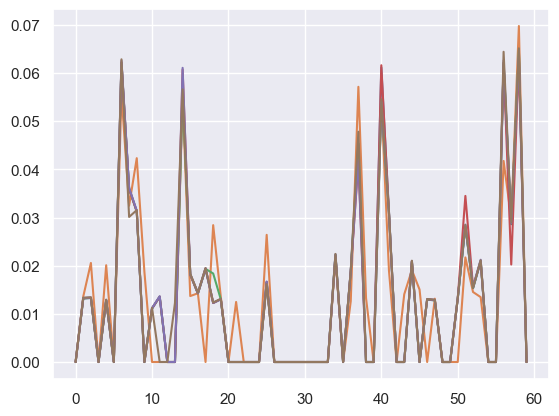

In [61]:
# basically how similar these 6 songs are across the 60 dim embedding for song topics
# So we see the similar songs here have a similar topic embedding
x = range(len(descr[0]))
for d in descr:
    plt.plot(x, d)

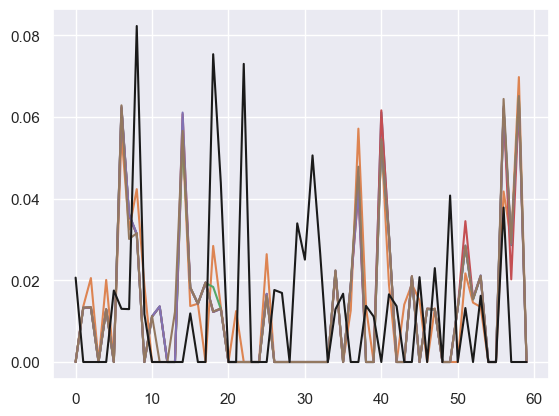

In [65]:
for d in descr:
    plt.plot(x,d)
plt.plot(x,dataset.df_topics.topics.iloc[np.random.randint(len(dataset.df_topics))], color='k') # plotting random song in addition for comparison

### Song embeddings

Similar analysis with song embeddings

In [71]:
dataset.df_song_embeddings.head(3)

,song_embedding
urlSong,
http://lyrics.wikia.com/A:Nothing,"[0.062323473, 0.011001364, 0.017321503, -0.039..."
http://lyrics.wikia.com/A:Something%27s_Going_On,"[0.05439434, 0.03371428, 0.013166547, -0.06471..."
http://lyrics.wikia.com/A:Starbucks,"[0.028431151, 0.041570004, 0.004875674, -0.036..."


Song embeddings for covers of the same song

In [79]:
def return_keyword_embeddings(song_term):
    descr = []
    for urlSong in list(dataset.df_song_embeddings[dataset.df_song_embeddings.index.str.lower().str.contains(song_term)].index):
        # print(urlSong)
        descr.append(dataset.df_song_embeddings[dataset.df_song_embeddings.index==urlSong].song_embedding.iloc[0])
        return descr



In [108]:
song_embds = return_keyword_embeddings('the_man_who_sold')

def plot_with_random_embds(descr, random_count):
    for i in range(random_count):
        descr.append(dataset.df_song_embeddings.song_embedding.iloc[
            np.random.randint(len(dataset.df_song_embeddings))])

    descr = np.array(descr)

    dists = np.linalg.norm(descr[:, None, :] - descr[None, :, :], axis=-1)
    plt.imshow(dists)

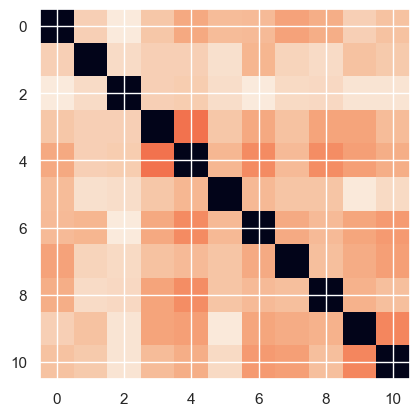

In [109]:
plot_with_random_embds(song_embds, 10)